# Telling the History of a District with Open Data

![title](./data/pexels-tima-miroshnichenko-7033891-20220313-154950.jpg)

## Step 0: Load Libraries & Data

In [ ]:
#standard libraries
import os
import pandas as pd
import numpy as np
import regex as re

#for visuals
import matplotlib.pyplot as plt

#for webscraping
from urllib.request import urlopen

In [ ]:
df = pd.read_csv('./data/KULTURWIKIOGD.csv')

In [ ]:
df.head(2)

,FID,OBJECTID,SHAPE,ADRESSE,ANDERE_BEZEICHNUNG,ART_DER_ORGANISATION,ART_DES_BAUWERKS,ART_DES_EREIGNISSES,ART_DES_OBJEKTS,BENANNT_NACH,...,KATEGORIE_TXT,LAGE,NAME_SEIT,PAGEID,PROMINENTE_BEWOHNER,PROMINENTE_PERSONEN,SEITENNAME,STADTPLAN,WEBLINK1,SE_ANNO_CAD_DATA
0,KULTURWIKIOGD.fid-4cb0c011_17f75b911c4_41df,294006,POINT (16.244504291918773 48.207665864191334),"14., Mondweg 91",NaN,NaN,NaN,NaN,Grünfläche,Franz Sauer,...,topografische_objekte,Wolfersberg,NaN,24895,NaN,NaN,Franz-Sauer-Park,1,https://www.geschichtewiki.wien.gv.at/?curid=2...,NaN
1,KULTURWIKIOGD.fid-4cb0c011_17f75b911c4_41e0,294007,POINT (16.258101639280678 48.19710480431093),"13., Rußpekgasse 3",NaN,NaN,NaN,NaN,Grünfläche,Franz Schimon,...,topografische_objekte,Hacking,NaN,45236,NaN,NaN,Franz-Schimon-Park,1,https://www.geschichtewiki.wien.gv.at/?curid=4...,NaN


## Step 1: First Analysis & Filter

In [ ]:
df['DISTRICT'] = df['ADRESSE'].str[0:2]
df['STREET'] = df['ADRESSE'].str[5:]

In [ ]:
df_n = df[df['DISTRICT'] == '07']
df_n.count

df_n.drop(columns=['FID','OBJECTID', 'ADRESSE', 'BEZIRK', 'BEZIRK_TXT', 'EINLAGEZAHL',
                    'FRUEHERE_BEZEICHNUNG', 'KATEGORIE', 'LAGE', 'PAGEID', 'STADTPLAN', 'SE_ANNO_CAD_DATA'], inplace=True)
df_n.head(2)
#df_n.shape

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,SHAPE,ANDERE_BEZEICHNUNG,ART_DER_ORGANISATION,ART_DES_BAUWERKS,ART_DES_EREIGNISSES,ART_DES_OBJEKTS,BENANNT_NACH,DATUM_BIS,DATUM_VON,KATEGORIE_TXT,NAME_SEIT,PROMINENTE_BEWOHNER,PROMINENTE_PERSONEN,SEITENNAME,WEBLINK1,DISTRICT,STREET
71,POINT (16.345987015649527 48.201070040884055),NaN,NaN,NaN,NaN,Grätzel,Reichtum der ansässigen Handwerker,NaN,NaN,TopografischeObjekte,NaN,NaN,NaN,Brillantengrund,https://www.geschichtewiki.wien.gv.at/?curid=7537,07,Bandgasse 6
128,POINT (16.345714016431135 48.2005820408563),NaN,NaN,NaN,NaN,Grünfläche,Dorothea Neff,NaN,NaN,topografische_objekte,NaN,NaN,NaN,Dorothea-Neff-Park,https://www.geschichtewiki.wien.gv.at/?curid=3...,07,Bandgasse 5/1


<AxesSubplot:>

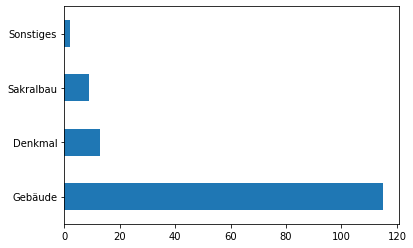

In [ ]:
df_n.ART_DES_BAUWERKS.value_counts().plot(kind='barh')

<AxesSubplot:>

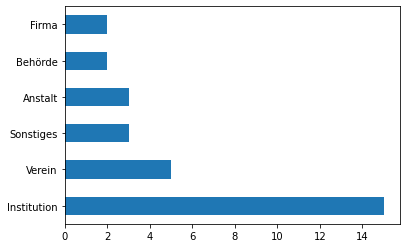

In [ ]:
df_n.ART_DER_ORGANISATION.value_counts().plot(kind='barh')

<AxesSubplot:>

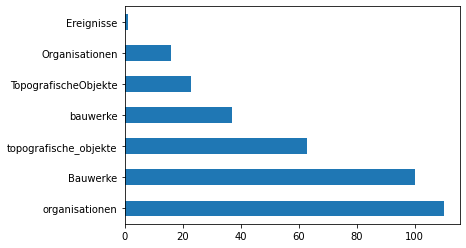

In [ ]:
df_n.KATEGORIE_TXT.value_counts().plot(kind='barh')

### Step 1.1: Analysis of Missing Values

In [ ]:
def visualize_missing_values(dataframe):
    numer_of_na = dataframe.isnull().sum(axis = 0)
    numer_of_na = numer_of_na.to_frame()

    numer_of_a = dataframe.notnull().sum(axis = 0)
    numer_of_a = numer_of_a.to_frame()

    index = numer_of_na

    #specify resolution
    plt.figure(figsize=(20, 7), dpi=90)

    #print bars
    plt.bar(numer_of_na.index, height=numer_of_a[0], color='#6ce083', label='Not Available')
    plt.bar(numer_of_na.index, bottom=numer_of_a[0], height=numer_of_na[0], color='#899a9f', label='Available')
    plt.legend()
    plt.title('Overview of Missing Values')

    #show values of bars
    for index, value in enumerate(numer_of_a[0]):
        plt.text(index,value, str(value),  ha='left', va='top',)

    #label the plot
    plt.xlabel('Features')
    plt.ylabel('Number of Available Data Records')

    #rotate x labels
    _ = plt.xticks(rotation=60)

 

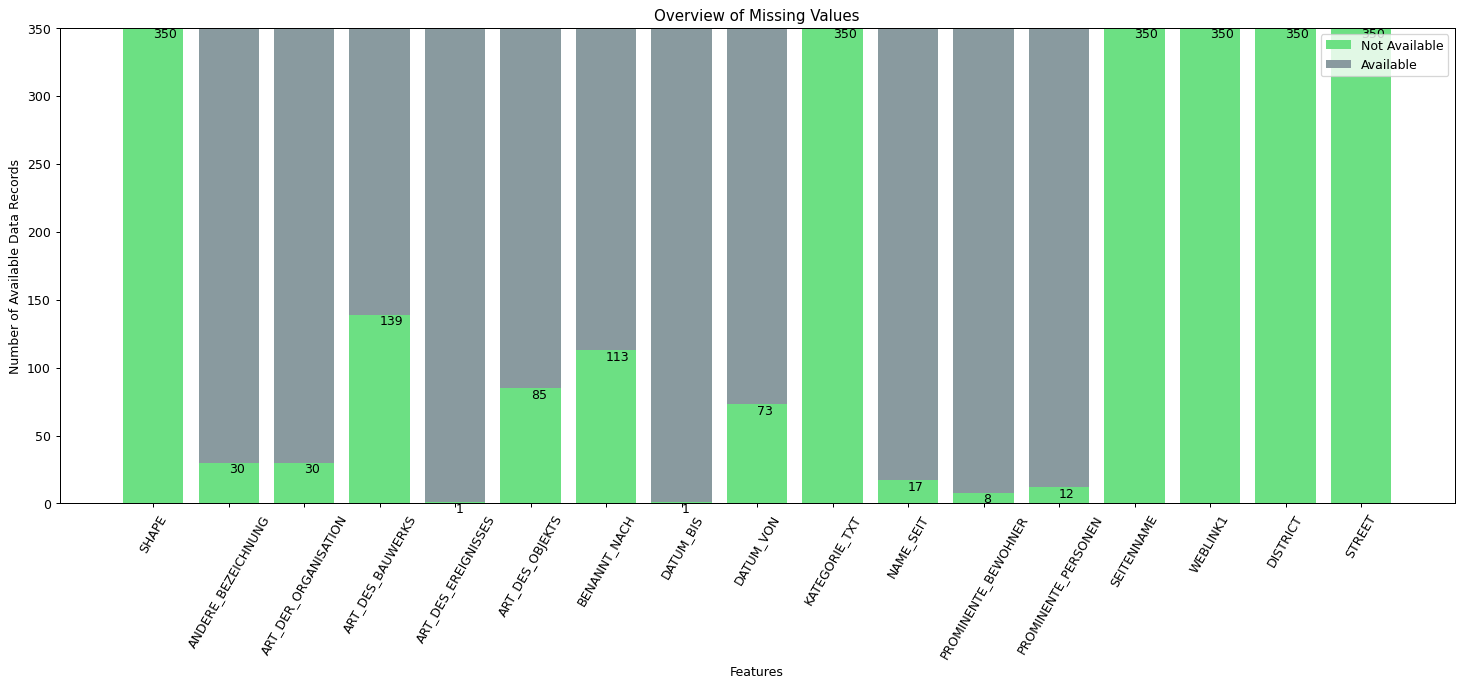

In [ ]:
visualize_missing_values(df_n)

## Step 2: Extending the Dataset by Webscraping

In [ ]:
def look_up_facts(url):

    #open the page
    page = urlopen(url)

    #read html and convert it to a string
    html_bytes = page.read()
    html = str(html_bytes.decode("utf-8"))

    #find the start year
    position = html.find('<td>Datum von')
    try:
        year_begin = int(html[position:position+28][24:])
    except:
        year_begin = None

    #find the end year
    position = html.find('<td>Datum bis')
    try:
        year_end = int(html[position:position+28][24:])
    except:
        year_end = None

    #find the type of object
    position = html.find('<tr>\n<td>Art')
    object_type = html[position:position+150]
    
    if '&amp;action=formedit&amp;redlink=1"' in object_type:
        object_type = object_type[object_type.find('title='):object_type.find('&amp;')][6:]
    else:
        object_type = object_type[object_type.find('title='):object_type.find('">')][7:]



    return year_begin, year_end, object_type


look_up_facts('https://www.geschichtewiki.wien.gv.at/Wien_Geschichte_Wiki?curid=12421')
look_up_facts('https://www.geschichtewiki.wien.gv.at/?curid=25703')

	

(None, None, 'Sakrale_Freiplastik')

In [ ]:
row_counter=0
import numpy as np

df_n['OBJECTTYPE'] = ''

for i in df_n.iterrows():
    
    #look up the information on the web
    year_begin, year_end, object_type  = look_up_facts(df_n['WEBLINK1'].iloc[row_counter])

    if year_begin != None and np.isnan(df_n['DATUM_VON'].iloc[row_counter]):
        df_n['DATUM_VON'].iloc[row_counter] = year_begin

    if year_end != None and np.isnan(df_n['DATUM_BIS'].iloc[row_counter]):
        df_n['DATUM_BIS'].iloc[row_counter] = year_end

    df_n['OBJECTTYPE'].iloc[row_counter] = object_type
        
    row_counter +=1

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

In [ ]:
df_n.to_csv('./data/KULTURWIKIOGD_modfied.csv')

In [ ]:
df_extended = pd.read_csv('./data/KULTURWIKIOGD_modfied.csv')

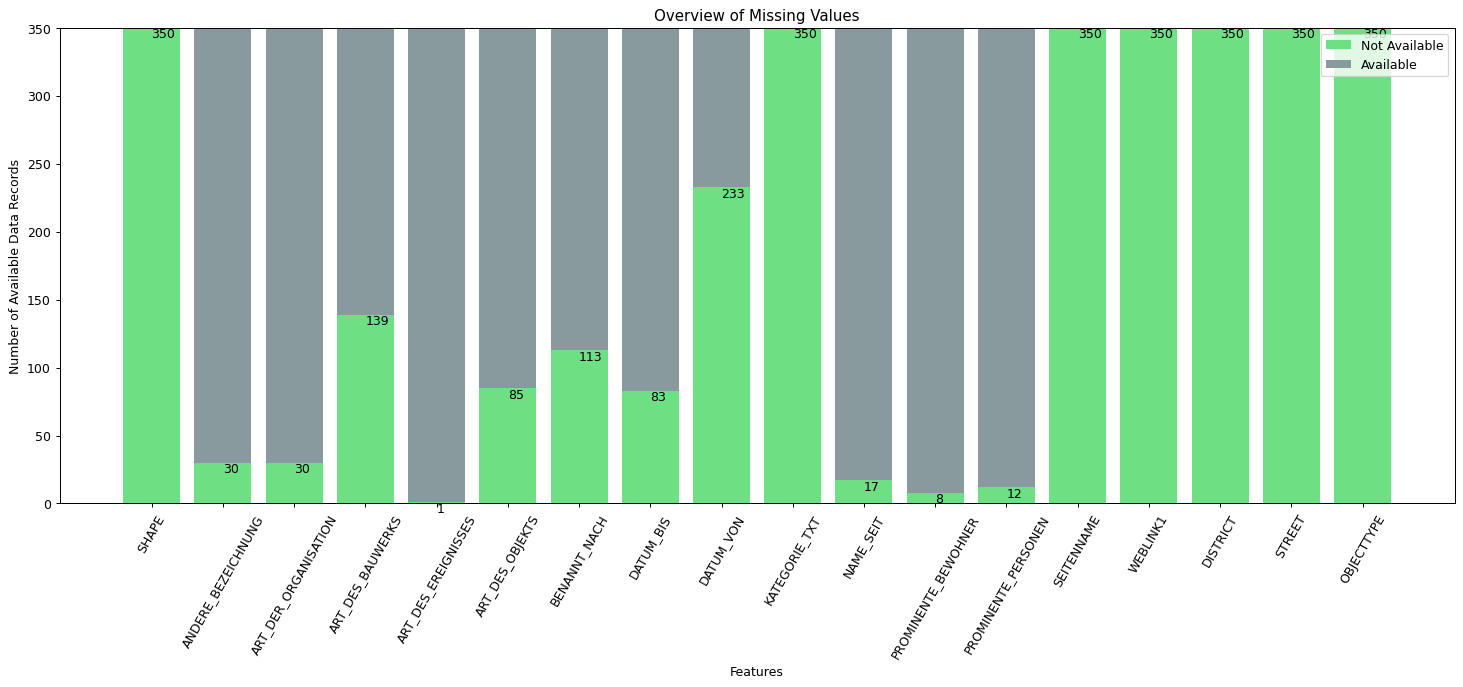

In [ ]:
visualize_missing_values(df_n)

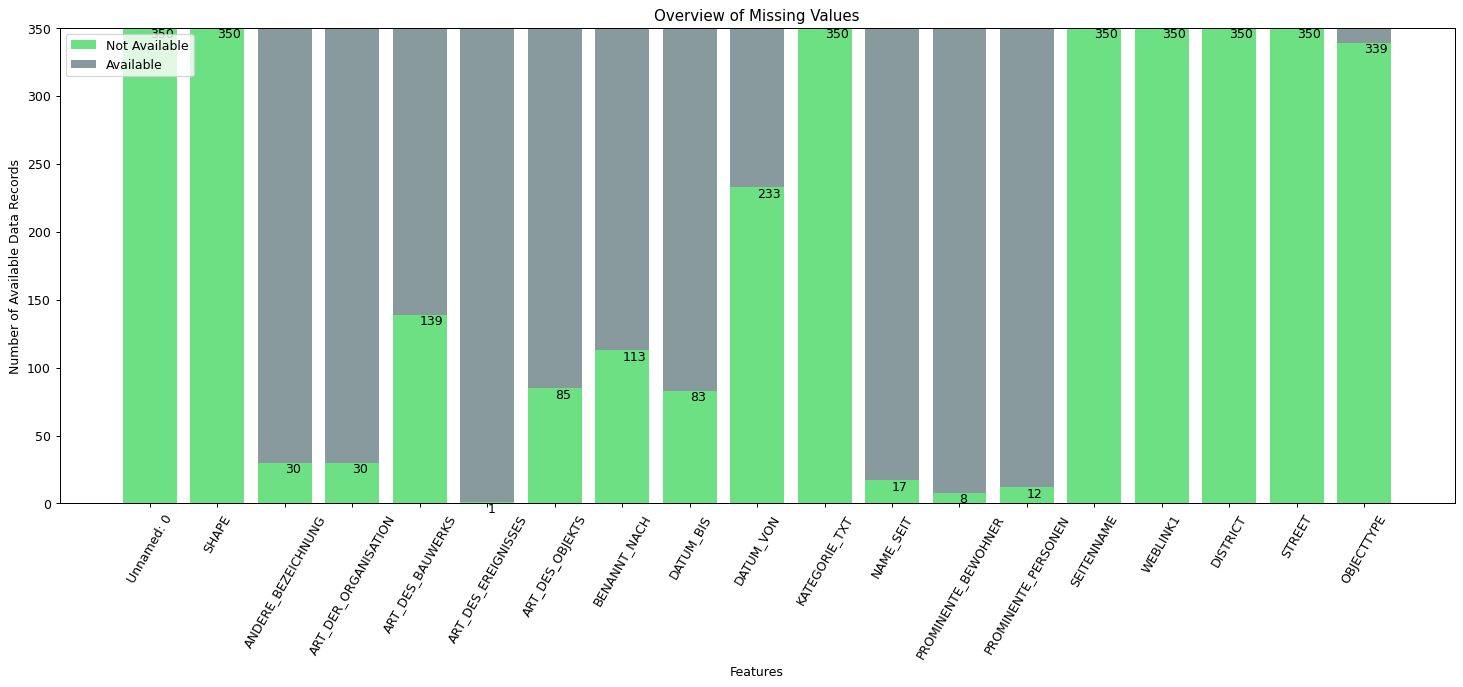

In [ ]:
visualize_missing_values(df_extended)

## Step 3: Cleaning the Data & Second Round of Analysis

In [ ]:

row_counter = 0

df_extended['TYPE'] = ''

for i in df_extended.iterrows():
    

    if df_extended['ART_DER_ORGANISATION'].iloc[row_counter] != '' and str(df_extended['ART_DER_ORGANISATION'].iloc[row_counter]) != 'nan':

        df_extended['TYPE'].iloc[row_counter] = df_extended['ART_DER_ORGANISATION'].iloc[row_counter]
    
    else:

        if df_extended['OBJECTTYPE'].iloc[row_counter] != '' and str(df_extended['OBJECTTYPE'].iloc[row_counter]) != 'nan':
            df_extended['TYPE'].iloc[row_counter] = df_extended['OBJECTTYPE'].iloc[row_counter]
        
        else:
            if str(df_extended['ART_DES_EREIGNISSES'].iloc[row_counter]) != 'nan':
                df_extended['TYPE'].iloc[row_counter] = df_extended['ART_DES_EREIGNISSES'].iloc[row_counter]
                df_extended['DATUM_VON'].iloc[row_counter]  = int(str(df_extended['DATUM_BIS'].iloc[row_counter])[:4])
                df_extended['DATUM_BIS'].iloc[row_counter]  = 0
            
            else:
                df_extended['TYPE'].iloc[row_counter] = df_extended['KATEGORIE_TXT'].iloc[row_counter]
                print(df_extended['KATEGORIE_TXT'].iloc[row_counter])

    #print(str(df_extended['TYPE'].iloc[row_counter]).lower())
    if  str(df_extended['TYPE'].iloc[row_counter]).lower() == 'sonstiges':

        object_type = df_extended['SEITENNAME'].iloc[row_counter]
        df_extended['TYPE'].iloc[row_counter] = object_type[object_type.find('('):object_type.find(')')][1:].replace('7,', '')
    
    if  str(df_extended['TYPE'].iloc[row_counter]).lower() == 'bauwerke':
        print('yes')
        df_extended['TYPE'].iloc[row_counter] = 'Denkmal'
        
    row_counter +=1

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
Bauwerke
yes
Bauwerke
yes
bauwerke
yes
bauwerke
yes
Bauwerke
yes
Bauwerke
yes
Bauwerke
yes
Bauwerke
yes
bauwerke
yes
topografische_objekte


In [ ]:
df_extended

new = df_extended[['SEITENNAME', 'TYPE', 'DATUM_VON', 'DATUM_BIS', 'BENANNT_NACH', 'PROMINENTE_BEWOHNER', 
                    'PROMINENTE_PERSONEN','STREET', 'DISTRICT', 'SHAPE', 'WEBLINK1']].copy()

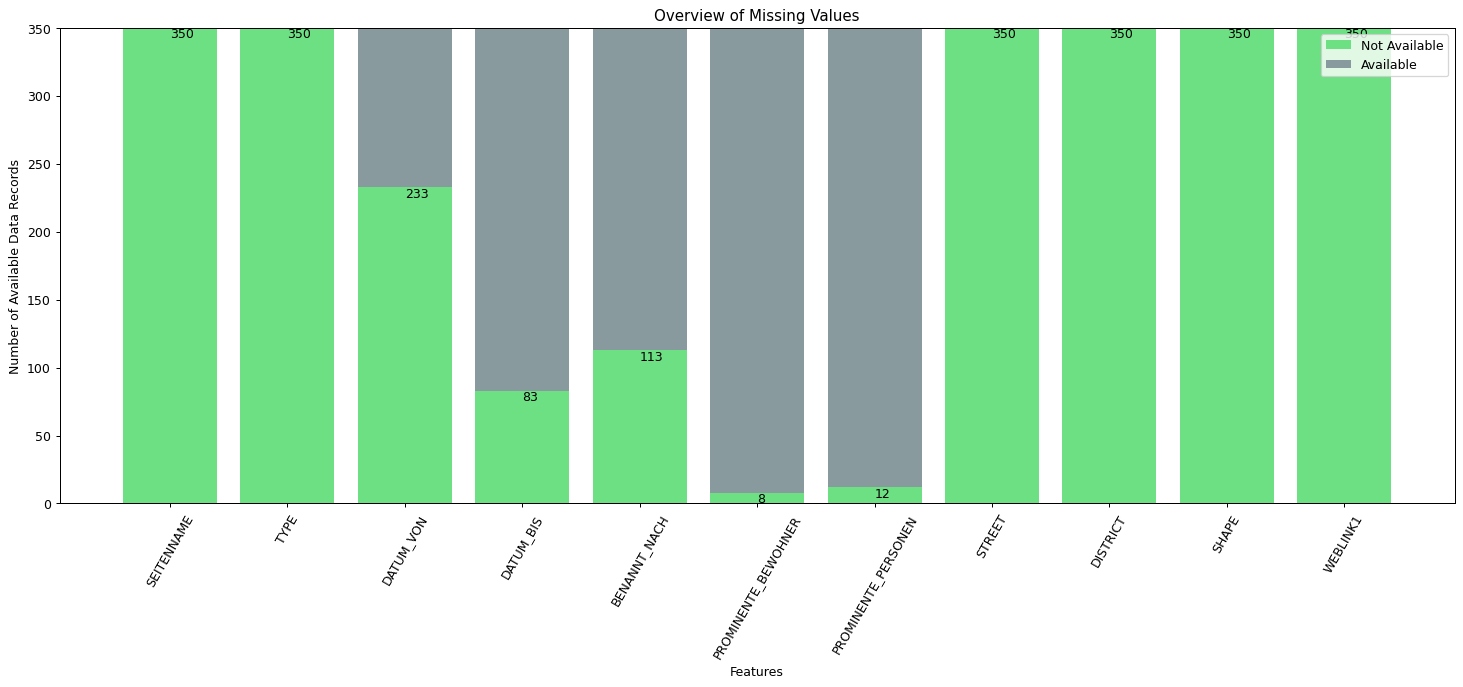

In [ ]:
visualize_missing_values(new)

In [ ]:
#new = new.apply(pd.to_numeric, downcast='integer', errors='ignore')
new['DATUM_VON'] = new['DATUM_VON'].fillna(0).astype('int64', errors='ignore')
new['DATUM_BIS'] = new['DATUM_BIS'].fillna(0).astype('int64', errors='ignore')

new = new.drop(new[new.DATUM_VON == 0].index)

new.sort_values(by=['DATUM_VON', 'DATUM_BIS']).style

#for i in  new.dtypes:
 #   print(i)

,SEITENNAME,TYPE,DATUM_VON,DATUM_BIS,BENANNT_NACH,PROMINENTE_BEWOHNER,PROMINENTE_PERSONEN,STREET,DISTRICT,SHAPE,WEBLINK1
261,Neustiftgasse,Verkehrsfläche,1100,0,Neustift (Vorstadt),nan,nan,Neustiftgasse 64,7,POINT (16.346672114243322 48.20559952082156),https://www.geschichtewiki.wien.gv.at/?curid=18519
297,St. Ulrich (Vorstadt),Vorstadt,1202,1850,Ulrichskirche,nan,nan,Neustiftgasse 31,7,POINT (16.352542015515514 48.205221040942796),https://www.geschichtewiki.wien.gv.at/?curid=21407
43,Ulrichskirche,Katholische Kirche,1211,0,St. Ulrich (Vorstadt),nan,nan,St.-Ulrichs-Platz 5,7,POINT (16.352570959505886 48.20476635284142),https://www.geschichtewiki.wien.gv.at/?curid=711
310,Neustift (Vorstadt),Vorstadt,1315,1850,nan,nan,nan,Neustiftgasse 60,7,POINT (16.347501015979635 48.20555004115885),https://www.geschichtewiki.wien.gv.at/?curid=18490
93,Berchtesgadner Hof,Gebäude,1333,1529,Probst von Berchtesgaden,nan,nan,Burggasse 22,7,POINT (16.352930991859658 48.20440306441252),https://www.geschichtewiki.wien.gv.at/?curid=30213
132,Neudeggerhof,Gebäude,1376,0,nan,nan,nan,Lerchenfelder Straße 25,7,POINT (16.351909225942467 48.206229823002204),https://www.geschichtewiki.wien.gv.at/?curid=17208
303,Mariahilf (Vorstadt),Vorstadt,1428,1850,nan,nan,nan,Mariahilfer Straße 52,7,POINT (16.35279101546011 48.19936604057346),https://www.geschichtewiki.wien.gv.at/?curid=25214
55,Kapuziner (Orden),Institution,1525,0,nan,nan,Franz von Assisi,Mechitaristengasse 2,7,POINT (16.354340222094947 48.205491929412304),https://www.geschichtewiki.wien.gv.at/?curid=32407
308,Neubau (Vorstadt),Vorstadt,1540,1850,nan,nan,nan,Neubaugasse 62,7,POINT (16.349019016143558 48.20312504108206),https://www.geschichtewiki.wien.gv.at/?curid=16984
161,Zum goldenen Fagott,Gebäude,1578,0,nan,nan,nan,Zollergasse 31,7,POINT (16.35038204518491 48.20079946212197),https://www.geschichtewiki.wien.gv.at/?curid=11853


<AxesSubplot:>

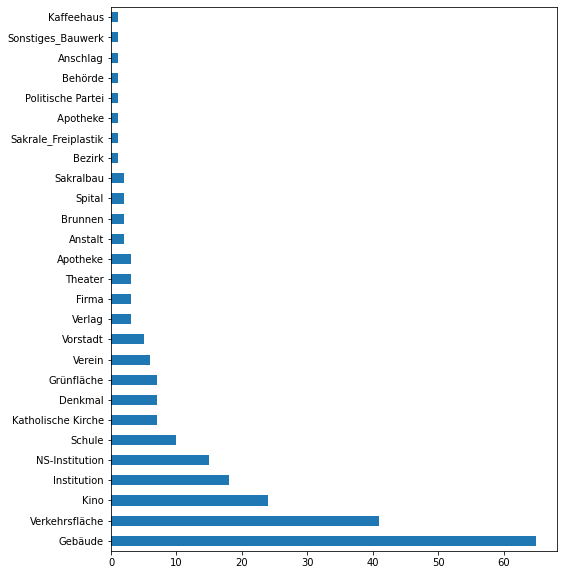

In [ ]:
new.TYPE.value_counts().plot(kind='barh',figsize=(8,10))

### Aggregate and Remove Object types

In [ ]:
new.reset_index(inplace=True)
new.drop("index", axis=1, inplace=True)

In [ ]:

unwanted_objects = ["Verkehrsfläche", "Bezirk", "Vorstadt", "Sakrale_Freiplastik", "Sakralbau", "Politische Partei", "Behörde"]
business_objects = ["Firma", "Verlag", "Institution", "Verein"]
health_objects = ["Apotheke", " Apotheke", "Spital", "Anstalt"]

row_counter = 0
for i in new.iterrows():
    
    object_type = new['TYPE'].iloc[row_counter]

    if object_type in unwanted_objects:
        new['TYPE'].iloc[row_counter] = np.nan

    else:
        if object_type in business_objects:
            new['TYPE'].iloc[row_counter] = "Firma_Verlag_Institution"
        
        else:
            if object_type in health_objects:
                new['TYPE'].iloc[row_counter] = "Apotheke_Spital_Anstalt"

            else:
                if object_type == "Sonstiges_Bauwerk":
                    new['TYPE'].iloc[row_counter] = "Gebäude"


        
    row_counter +=1

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
new

,SEITENNAME,TYPE,DATUM_VON,DATUM_BIS,BENANNT_NACH,PROMINENTE_BEWOHNER,PROMINENTE_PERSONEN,STREET,DISTRICT,SHAPE,WEBLINK1
0,Dorothea-Neff-Park,Grünfläche,2007,0,Dorothea Neff,NaN,NaN,Bandgasse 5/1,7,POINT (16.345714016431135 48.2005820408563),https://www.geschichtewiki.wien.gv.at/?curid=3...
1,"Johannes-Nepomuk-Statue (7, Ulrichsplatz)",NaN,1750,0,Johannes Nepomuk,NaN,NaN,St.-Ulrichs-Platz 3(PFARRE),7,POINT (16.352570150538384 48.20476086708961),https://www.geschichtewiki.wien.gv.at/?curid=1...
2,Richtergasse,NaN,1862,0,"Hausschild ""Zur Gerechtigkeit""",NaN,NaN,Richtergasse 8,7,POINT (16.348221551258803 48.199278499796634),https://www.geschichtewiki.wien.gv.at/?curid=2...
3,Zum St. Ulrich (Apotheke),Apotheke_Spital_Anstalt,1713,0,NaN,NaN,NaN,Burggasse 22,7,POINT (16.35302526327066 48.204289915815366),https://www.geschichtewiki.wien.gv.at/?curid=2...
4,"Zum goldenen Elefanten (7, Apotheke)",Apotheke_Spital_Anstalt,1783,0,NaN,NaN,NaN,Siebensterngasse 20,7,POINT (16.35432653570176 48.202555822982),https://www.geschichtewiki.wien.gv.at/?curid=1...
...,...,...,...,...,...,...,...,...,...,...,...
228,Wohnhaus Bernardgasse,Gebäude,1925,0,Bernardgasse,NaN,NaN,Bernardgasse 38/1,7,POINT (16.33888602578309 48.20732831553085),https://www.geschichtewiki.wien.gv.at/?curid=6...
229,Wohnhaus Neustiftgasse,Gebäude,1925,0,Neustiftgasse,NaN,NaN,Neustiftgasse 143/1,7,POINT (16.338929543731112 48.20597555396534),https://www.geschichtewiki.wien.gv.at/?curid=6...
230,Verlag der Wiener Graphischen Werkstätte,Firma_Verlag_Institution,1918,1930,NaN,NaN,NaN,Kaiserstraße 45/1,7,POINT (16.34043006512766 48.201309821420296),https://www.geschichtewiki.wien.gv.at/?curid=6...
231,Atelier Setzer-Tschiedel,Firma_Verlag_Institution,1909,1979,NaN,NaN,NaN,Neustiftgasse 3,7,POINT (16.35617105430219 48.20527317944676),https://www.geschichtewiki.wien.gv.at/?curid=7...


In [ ]:
new["LAT"]  = 0
new["LONG"] = 0


row_counter = 0
for i in new.iterrows():
    
    coordinates = new['SHAPE'].iloc[row_counter]
    new['LONG'].iloc[row_counter]= coordinates.split(" ")[1].replace("(", "")
    new['LAT'].iloc[row_counter] = coordinates.split(" ")[2].replace(")", "")
        
    row_counter +=1

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:>

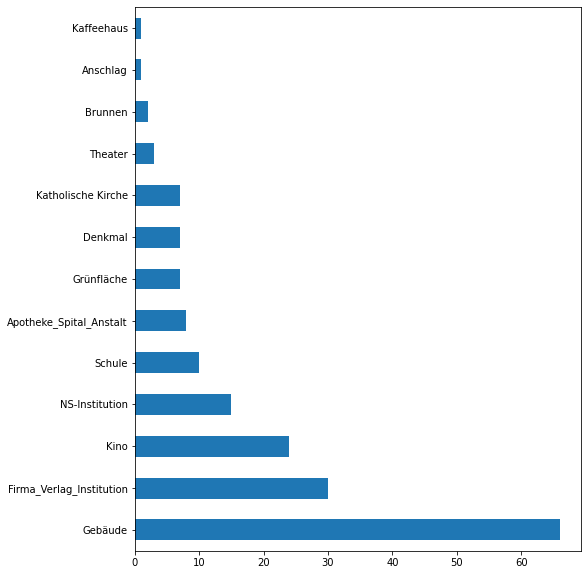

In [ ]:
new.TYPE.value_counts().plot(kind='barh',figsize=(8,10))

In [ ]:
row_counter = 0
for i in new.iterrows():
    
    object_type = new['TYPE'].iloc[row_counter]

    if object_type == "Katholische Kriche":
        new['TYPE'].iloc[row_counter] = "Kirche"
    else:
        if object_type == "Gebäude":
            new['TYPE'].iloc[row_counter] = "Bauwerk"
        else:
            if object_type == "Grünfläche":
                new['TYPE'].iloc[row_counter] = "Park"
            else: 
                if object_type == "NS-Institution":
                    new['TYPE'].iloc[row_counter] = "NS_Institution"
                else:
                    pass

        
    row_counter +=1

In [ ]:
new= pd.read_csv("./data/district_data.csv", sep=";")

In [ ]:
new.to_csv("./data/district_data.csv", sep =";")

## Analysis of Development over Time

Text(0.5, 0, 'Year')

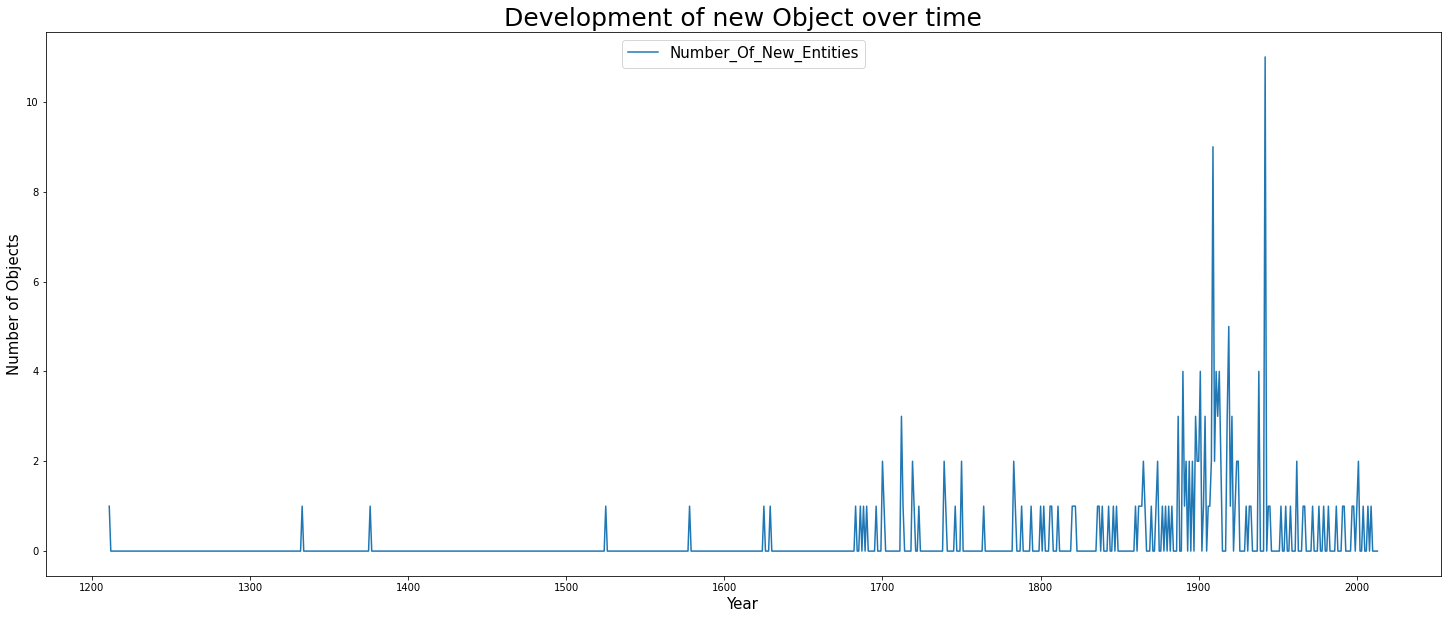

In [ ]:
data_per_year = new.groupby('DATUM_VON').count()['SEITENNAME']
data_per_year = data_per_year.to_frame().rename(columns={'SEITENNAME':'Number_Of_New_Entities'})


all_years = pd.Series(np.arange(new['DATUM_VON'].min(), new['DATUM_VON'].max())).to_frame()
all_years['Number_Of_New_Entities'] = 0
all_years.set_index(0, inplace=True)



data_per_year = all_years.combine(data_per_year, np.maximum).fillna(0)

ax = data_per_year.plot(figsize=(25,10))

ax.set_title('Development of new Object over time')
ax.title.set_size(25)
ax.legend(loc=9, prop={'size': 15})
ax.set_ylabel('Number of Objects', fontsize=15)
ax.set_xlabel('Year', fontsize=15)

(0.0, 189.0)

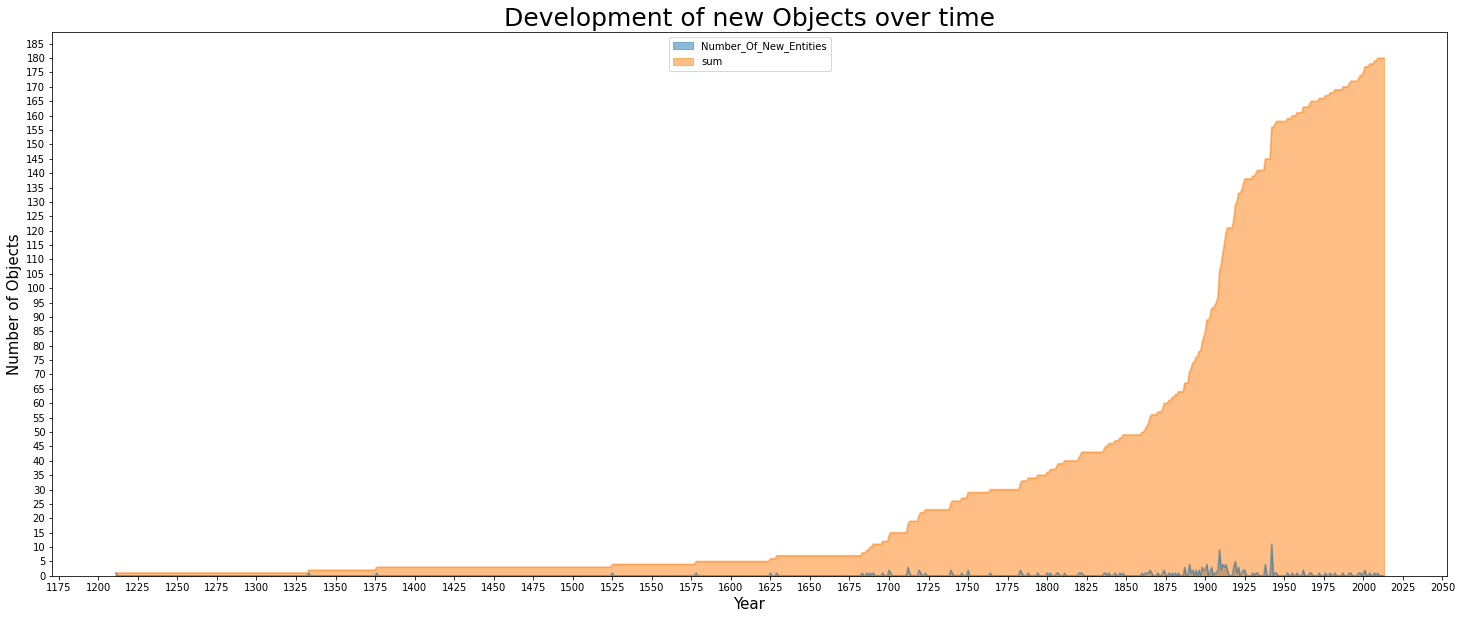

In [ ]:

data_per_year = data_per_year.assign(sum=data_per_year.values.cumsum())

ax = data_per_year.plot(kind ='area',figsize=(25,10), stacked=False)

ax.set_title('Development of new Objects over time')
ax.title.set_size(25)
ax.legend(loc=9, prop={'size': 10})
ax.set_ylabel('Number of Objects', fontsize=15)
ax.set_xlabel('Year', fontsize=15)

#display xasis as integer and set how many years should be displayed
ax.locator_params(integer=True, nbins=20, min_n_ticks=20)
ax.set_ylim(ymin=0)

In [ ]:
new

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1,SEITENNAME,...,DATUM_BIS,BENANNT_NACH,PROMINENTE_BEWOHNER,PROMINENTE_PERSONEN,STREET,DISTRICT,SHAPE,WEBLINK1,LONG,LAT
0,0,0,0,0,0,0,0,0,1,Dorothea-Neff-Park,...,0,Dorothea Neff,NaN,NaN,Bandgasse 5/1,7,POINT (16.345714016431135 48.2005820408563),https://www.geschichtewiki.wien.gv.at/?curid=3...,16.345714,48.200582
1,1,1,1,1,1,1,1,1,5,Zum St. Ulrich (Apotheke),...,0,NaN,NaN,NaN,Burggasse 22,7,POINT (16.35302526327066 48.204289915815366),https://www.geschichtewiki.wien.gv.at/?curid=2...,16.353025,48.204290
2,2,2,2,2,2,2,2,2,6,"Zum goldenen Elefanten (7, Apotheke)",...,0,NaN,NaN,NaN,Siebensterngasse 20,7,POINT (16.35432653570176 48.202555822982),https://www.geschichtewiki.wien.gv.at/?curid=1...,16.354327,48.202556
3,3,3,3,3,3,3,3,3,7,Löwinger-Bühne,...,0,NaN,NaN,"Cilli Löwinger,Paul Löwinger (senior),Sissy Lö...",Neubaugasse 36/1,7,POINT (16.3494000247669 48.20136633307758),https://www.geschichtewiki.wien.gv.at/?curid=2...,16.349400,48.201366
4,4,4,4,4,4,4,4,4,9,Mechitaristen,...,0,Mechithar von Sebaste,NaN,NaN,Mechitaristengasse 2,7,POINT (16.354299614872517 48.2055570467795),https://www.geschichtewiki.wien.gv.at/?curid=2...,16.354300,48.205557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,176,176,176,176,176,176,176,176,328,Wohnhaus Bernardgasse,...,0,Bernardgasse,NaN,NaN,Bernardgasse 38/1,7,POINT (16.33888602578309 48.20732831553085),https://www.geschichtewiki.wien.gv.at/?curid=6...,16.338886,48.207328
177,177,177,177,177,177,177,177,177,329,Wohnhaus Neustiftgasse,...,0,Neustiftgasse,NaN,NaN,Neustiftgasse 143/1,7,POINT (16.338929543731112 48.20597555396534),https://www.geschichtewiki.wien.gv.at/?curid=6...,16.338930,48.205976
178,178,178,178,178,178,178,178,178,330,Verlag der Wiener Graphischen Werkstätte,...,1930,NaN,NaN,NaN,Kaiserstraße 45/1,7,POINT (16.34043006512766 48.201309821420296),https://www.geschichtewiki.wien.gv.at/?curid=6...,16.340430,48.201310
179,179,179,179,179,179,179,179,179,331,Atelier Setzer-Tschiedel,...,1979,NaN,NaN,NaN,Neustiftgasse 3,7,POINT (16.35617105430219 48.20527317944676),https://www.geschichtewiki.wien.gv.at/?curid=7...,16.356171,48.205273


Text(0.5, 0, 'Year')

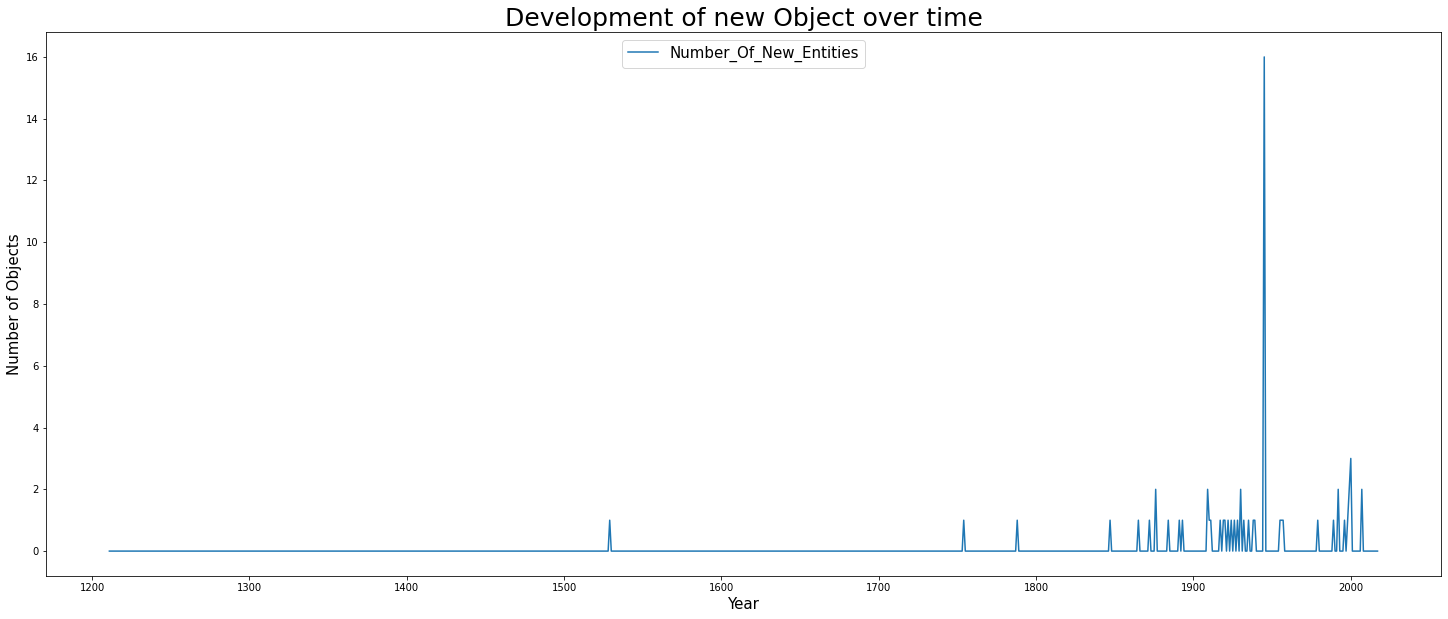

In [ ]:
data_per_year = new.drop(new[new['DATUM_BIS'] == 0].index).groupby('DATUM_BIS').count()['SEITENNAME']
data_per_year = data_per_year.to_frame().rename(columns={'SEITENNAME':'Number_Of_New_Entities'})


all_years = pd.Series(np.arange(new['DATUM_VON'].min(), new['DATUM_BIS'].max())).to_frame()
all_years['Number_Of_New_Entities'] = 0
all_years.set_index(0, inplace=True)



data_per_year = all_years.combine(data_per_year, np.maximum).fillna(0)

ax = data_per_year.plot(figsize=(25,10))

ax.set_title('Development of new Object over time')
ax.title.set_size(25)
ax.legend(loc=9, prop={'size': 15})
ax.set_ylabel('Number of Objects', fontsize=15)
ax.set_xlabel('Year', fontsize=15)

(0.0, 63.0)

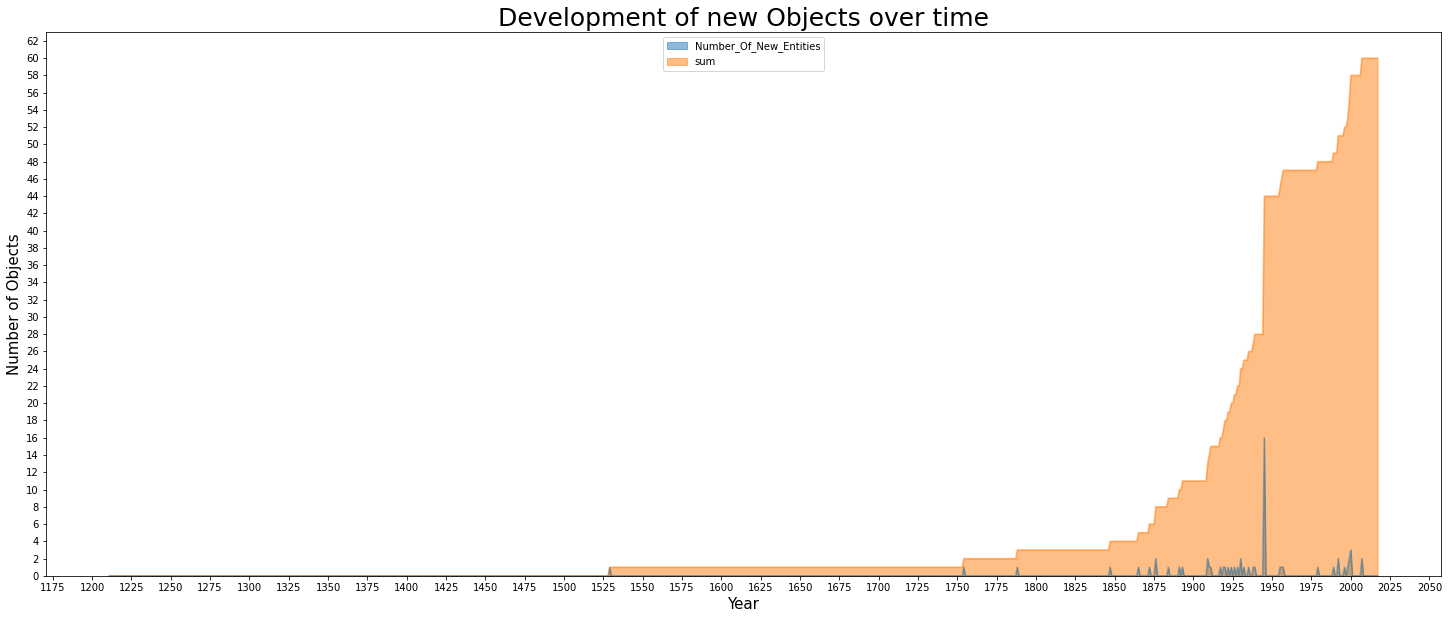

In [ ]:
data_per_year = data_per_year.assign(sum=data_per_year.values.cumsum())

ax = data_per_year.plot(kind ='area',figsize=(25,10), stacked=False)

ax.set_title('Development of new Objects over time')
ax.title.set_size(25)
ax.legend(loc=9, prop={'size': 10})
ax.set_ylabel('Number of Objects', fontsize=15)
ax.set_xlabel('Year', fontsize=15)

#display xasis as integer and set how many years should be displayed
ax.locator_params(integer=True, nbins=20, min_n_ticks=20)
ax.set_ylim(ymin=0)

In [ ]:
data_per_year

,Number_Of_New_Entities,sum
1211,0.0,0.0
1212,0.0,0.0
1213,0.0,0.0
1214,0.0,0.0
1215,0.0,0.0
...,...,...
2013,0.0,60.0
2014,0.0,60.0
2015,0.0,60.0
2016,0.0,60.0


## Handle the coordinates file

In [ ]:
coord_df = pd.read_csv("./data/BEZIRKSGRENZEOGD.csv")

In [ ]:
coord_df[]

,FID,SHAPE,NAMEK,BEZNR,BEZ_RZ,NAMEK_NUM,NAMEK_RZ,NAMEG,LABEL,BEZ,DISTRICT_CODE,STATAUSTRIA_BEZ_CODE,STATAUSTRIA_GEM_CODE,FLAECHE,UMFANG,AKT_TIMESTAMP,SE_SDO_ROWID,SE_ANNO_CAD_DATA
0,BEZIRKSGRENZEOGD.11207,POLYGON ((16.327324497777646 48.20500462816456...,Rudolfsheim-Fünfhaus,15,XV,"15., Rudolfsheim-Fünfhaus",XV. Rudolfsheim-Fünfhaus,RUDOLFSHEIM-FÜNFHAUS,XV.,15,1150,915,91501,3.918463e+06,9713.17,2022-02-16,11207,NaN
1,BEZIRKSGRENZEOGD.11208,"POLYGON ((16.33872503860187 48.20853687769482,...",Neubau,7,VII,"7., Neubau",VII. Neubau,NEUBAU,VII.,7,1070,907,90701,1.608248e+06,5312.54,2022-02-16,11208,NaN
2,BEZIRKSGRENZEOGD.11209,POLYGON ((16.396616911956556 48.20738650411634...,Landstraße,3,III,"3., Landstraße",III. Landstraße,LANDSTRASSE,III.,3,1030,903,90301,7.403077e+06,13962.28,2022-02-16,11209,[B@1bd2fd93
3,BEZIRKSGRENZEOGD.11210,"POLYGON ((16.34914738057747 48.21515778657998,...",Josefstadt,8,VIII,"8., Josefstadt",VIII. Josefstadt,JOSEFSTADT,VIII.,8,1080,908,90801,1.089946e+06,4170.30,2022-02-16,11210,NaN
4,BEZIRKSGRENZEOGD.11211,POLYGON ((16.372640621929264 48.21661673091233...,Innere Stadt,1,I,"1., Innere Stadt",I. Innere Stadt,INNERE STADT,I.,1,1010,901,90101,2.868774e+06,6972.75,2022-02-16,11211,NaN
5,BEZIRKSGRENZEOGD.11212,POLYGON ((16.276206384428136 48.22703677399255...,Ottakring,16,XVI,"16., Ottakring",XVI. Ottakring,OTTAKRING,XVI.,16,1160,916,91601,8.673048e+06,18371.08,2022-02-16,11212,NaN
6,BEZIRKSGRENZEOGD.11213,POLYGON ((16.361652322599042 48.23191837846428...,Alsergrund,9,IX,"9., Alsergrund",IX. Alsergrund,ALSERGRUND,IX.,9,1090,909,90901,2.967385e+06,7919.54,2022-02-16,11213,NaN
7,BEZIRKSGRENZEOGD.11214,POLYGON ((16.403452708539085 48.23191876884834...,Leopoldstadt,2,II,"2., Leopoldstadt",II. Leopoldstadt,LEOPOLDSTADT,II.,2,1020,902,90201,1.924200e+07,27093.08,2022-02-16,11214,NaN
8,BEZIRKSGRENZEOGD.11215,POLYGON ((16.295017426146554 48.24960936007606...,Währing,18,XVIII,"18., Währing",XVIII. Währing,WÄHRING,XVIII.,18,1180,918,91801,6.347196e+06,18058.47,2022-02-16,11215,NaN
9,BEZIRKSGRENZEOGD.11216,POLYGON ((16.285159474332644 48.25680038253125...,Hernals,17,XVII,"17., Hernals",XVII. Hernals,HERNALS,XVII.,17,1170,917,91701,1.139633e+07,29407.73,2022-02-16,11216,NaN


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5971a028-c0d0-47c6-9067-1e50c9f81efe' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>